In [29]:
# %pip install --upgrade pip
# %pip install pandas matplotlib seaborn scikit-learn nltk tqdm ipywidgets wordcloud gensim pyldavis --user 

In [30]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pathlib
import json
import typing
import nltk
from tqdm.notebook import tqdm 

nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leeos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
def read_json(file_list: typing.List[str]):
    for file in file_list: 
        with open(file, "r") as json_file: 
            yield json.load(json_file)["articles"]

In [32]:
news_path: pathlib.Path = pathlib.Path("../../data/cnn/news/something-something/").resolve()
news_path = news_path.joinpath("*.json")
news_files = glob.glob(str(news_path))

df_full = pd.DataFrame()
for news in read_json(news_files):
    df_full = pd.concat([df_full, pd.DataFrame(news)], ignore_index=True)

In [33]:
df_full.head()

,headline,subtitle,updated_at,content,topics
0,{'title': 'Cuba concede permissão à China para...,"Em fevereiro, episódio envolvendo um balão es...",2023-06-08T14:37:00,Cuba concordou em permitir que a China constru...,"[{'topic': 'China', 'link': 'https://www.cnnbr..."
1,{'title': 'Quem é Sergio Massa? Das reviravolt...,Atual superministro da Economia na Argentina ...,2023-06-08T14:31:00,Ele tentou ser presidente da Argentina em 2015...,"[{'topic': 'Argentina', 'link': 'https://www.c..."
2,{'title': 'Fernando Diniz critica caso de raci...,Vídeos mostram torcedor do River Plate imitan...,2023-06-08T13:15:00,A derrota do Fluminense para o River Plate-ARG...,"[{'topic': 'CNN Esportes', 'link': 'https://ww..."
3,{'title': 'STF começa a julgar nesta sexta dec...,O julgamento será pelo plenário virtual do Su...,2023-06-08T14:27:00,A presidente do Supremo Tribunal Federal (STF)...,"[{'topic': 'Câmara dos Deputados', 'link': 'ht..."
4,{'title': 'Avião de Leila Pereira que será uti...,Aeronave será utilizada para dar agilidade e ...,None,O avião comprado em janeiro deste ano por Leil...,"[{'topic': 'CNN Esportes', 'link': 'https://ww..."


In [34]:
df_full.describe()

,headline,subtitle,updated_at,content,topics
count,1708,1708,1276,1708,1708
unique,1671,1652,1162,1671,1540
top,"{'title': 'Com tiroteio em escola no PR, Brasi...",,2023-06-18T10:46:00,"Ex-aluno, de 21 anos, abriu fogo dentro do Co...",[]
freq,2,6,4,2,26


In [35]:
headlines_df = df_full["headline"].apply(pd.Series)
df_full = df_full.join(headlines_df)
df_full.drop(columns=["headline"], inplace=True)

df_full["topics"] = df_full["topics"].apply(lambda x: [topic["topic"] for topic in x])
df_full["text"] = df_full["title"] + df_full["subtitle"] + df_full["content"]
df_full.drop(columns=["link", "title", "subtitle", "content"], inplace=True)

In [36]:
df_full.head()

,updated_at,topics,tag,created_at,text
0,2023-06-08T14:37:00,"[China, Cuba, espionagem, Estados Unidos, Joe ...",Internacional,2023-06-08T13:23:00,Cuba concede permissão à China para construir ...
1,2023-06-08T14:31:00,"[Argentina, Eleições]",Internacional,2023-06-08T13:22:00,Quem é Sergio Massa? Das reviravoltas com o ki...
2,2023-06-08T13:15:00,"[CNN Esportes, Copa Libertadores da América, F...",Esportes,2023-06-08T13:14:00,Fernando Diniz critica caso de racismo contra ...
3,2023-06-08T14:27:00,"[Câmara dos Deputados, Deltan Dallagnol, Dias ...",Política,2023-06-08T13:12:00,STF começa a julgar nesta sexta decisão sobre ...
4,None,"[CNN Esportes, Leila Pereira, Palmeiras]",Esportes,2023-06-08T13:07:00,Avião de Leila Pereira que será utilizado pelo...


In [37]:
df_news = df_full.copy()

df_news["created_at"] = pd.to_datetime(df_news["created_at"])
df_news["updated_at"] = pd.to_datetime(df_news["updated_at"])

df_news["creation_day"] = df_news["created_at"].apply(lambda x: int(x.day))
df_news["creation_month"] = df_news["created_at"].apply(lambda x: int(x.month))
df_news["creation_year"] = df_news["created_at"].apply(lambda x: int(x.year))



df_news["update_day"] = df_news["updated_at"].apply(lambda x: x.day if x.day else 0)
df_news["update_month"] = df_news["updated_at"].apply(lambda x: x.month if x.month else 0)
df_news["update_year"] = df_news["updated_at"].apply(lambda x: x.year if x.year else 0)

df_news.drop(columns=["created_at", "updated_at"], inplace=True)

In [38]:
df_news.head()

,topics,tag,text,creation_day,creation_month,creation_year,update_day,update_month,update_year
0,"[China, Cuba, espionagem, Estados Unidos, Joe ...",Internacional,Cuba concede permissão à China para construir ...,8,6,2023,8.0,6.0,2023.0
1,"[Argentina, Eleições]",Internacional,Quem é Sergio Massa? Das reviravoltas com o ki...,8,6,2023,8.0,6.0,2023.0
2,"[CNN Esportes, Copa Libertadores da América, F...",Esportes,Fernando Diniz critica caso de racismo contra ...,8,6,2023,8.0,6.0,2023.0
3,"[Câmara dos Deputados, Deltan Dallagnol, Dias ...",Política,STF começa a julgar nesta sexta decisão sobre ...,8,6,2023,8.0,6.0,2023.0
4,"[CNN Esportes, Leila Pereira, Palmeiras]",Esportes,Avião de Leila Pereira que será utilizado pelo...,8,6,2023,NaN,NaN,NaN


In [39]:
print(f"Number of unique topics: {df_news['topics'].explode().nunique()}")
print(f"Number of unique tags: {df_news['tag'].nunique()}")
print(f"Unique tags: {df_news['tag'].unique()}")

Number of unique topics: 2396
Number of unique tags: 9
Unique tags: ['Internacional' 'Esportes' 'Política' 'Nacional' 'Economia'
 'Entretenimento' 'Saúde' 'Tecnologia' 'Estilo']


C:\Users\leeos\AppData\Local\Temp\ipykernel_26760\3009409421.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


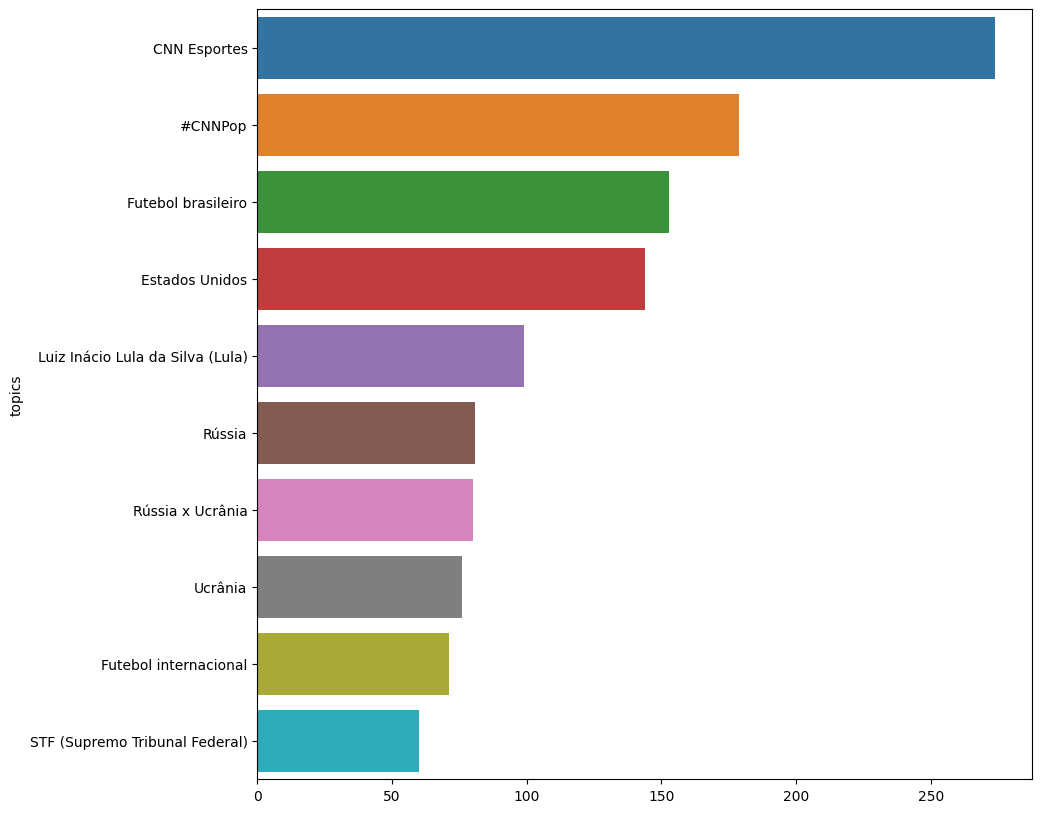

In [40]:
# Draw a graph that shows the number of news per topic
top_10_topics = df_news["topics"].explode().value_counts().head(10)

figure = plt.figure(figsize=(10, 10))
sns.barplot(x=top_10_topics.values, y=top_10_topics.index)
figure.show()

In [41]:
import nltk 
import string

def remove_punctuation(content: str) -> str:
    return content.translate(str.maketrans('', '', string.punctuation))

def stemmer(tokens):
    stemmer = nltk.stem.PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def lower(tokens):
    if isinstance(tokens, str):
        return tokens.lower()    

    return [token.lower() for token in tokens]

def lemma(content: str) -> str:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word) for word in content.split()])

def remove_numbers(content: str) -> str:
    return ''.join([i for i in content if not i.isdigit()])

def remove_words_by_length(corpus: str, min_length: int, max_length: int) -> str:
    return ' '.join([word for word in corpus.split() if min_length <= len(word) <= max_length])

def remove_stopwords(content): 
    stopwords = nltk.corpus.stopwords.words('portuguese')
    return ' '.join([word for word in content.split() if word not in stopwords])

def tokenize(content):
    return nltk.word_tokenize(content)

def pre_processing(content: str) -> str:
    """Pre process the content. 

    The Pre processing pipeline is:
        1. Lowercase the content
        3. Remove punctuation
        4. Remove numbers
        6. Lemmatize the content

    Args:
        content (str): The content to pre process.

    Returns:
        str: The pre processed content.
    """
    content = content.lower()
    content = remove_stopwords(content)
    content = remove_punctuation(content)
    content = remove_words_by_length(content, 2, 20)
    content = remove_numbers(content)
    return lemma(content)

In [42]:
df_news["text"] = df_news["text"].apply(pre_processing)
df_news["tokenized_text"] = df_news["text"].apply(tokenize)
df_news["topics"] = df_news["topics"].apply(lower)
df_news["tag"] = df_news["tag"].apply(lower)

In [43]:
df_news.head()

,topics,tag,text,creation_day,creation_month,creation_year,update_day,update_month,update_year,tokenized_text
0,"[china, cuba, espionagem, estados unidos, joe ...",internacional,cuba concede permissão china construir instala...,8,6,2023,8.0,6.0,2023.0,"[cuba, concede, permissão, china, construir, i..."
1,"[argentina, eleições]",internacional,sergio massa reviravoltas kirchnerismo possíve...,8,6,2023,8.0,6.0,2023.0,"[sergio, massa, reviravoltas, kirchnerismo, po..."
2,"[cnn esportes, copa libertadores da américa, f...",esportes,fernando diniz critica caso racismo contra tor...,8,6,2023,8.0,6.0,2023.0,"[fernando, diniz, critica, caso, racismo, cont..."
3,"[câmara dos deputados, deltan dallagnol, dias ...",política,stf começa julgar nesta sexta decisão sobre su...,8,6,2023,8.0,6.0,2023.0,"[stf, começa, julgar, nesta, sexta, decisão, s..."
4,"[cnn esportes, leila pereira, palmeiras]",esportes,avião leila pereira utilizado palmeiras chega ...,8,6,2023,NaN,NaN,NaN,"[avião, leila, pereira, utilizado, palmeiras, ..."


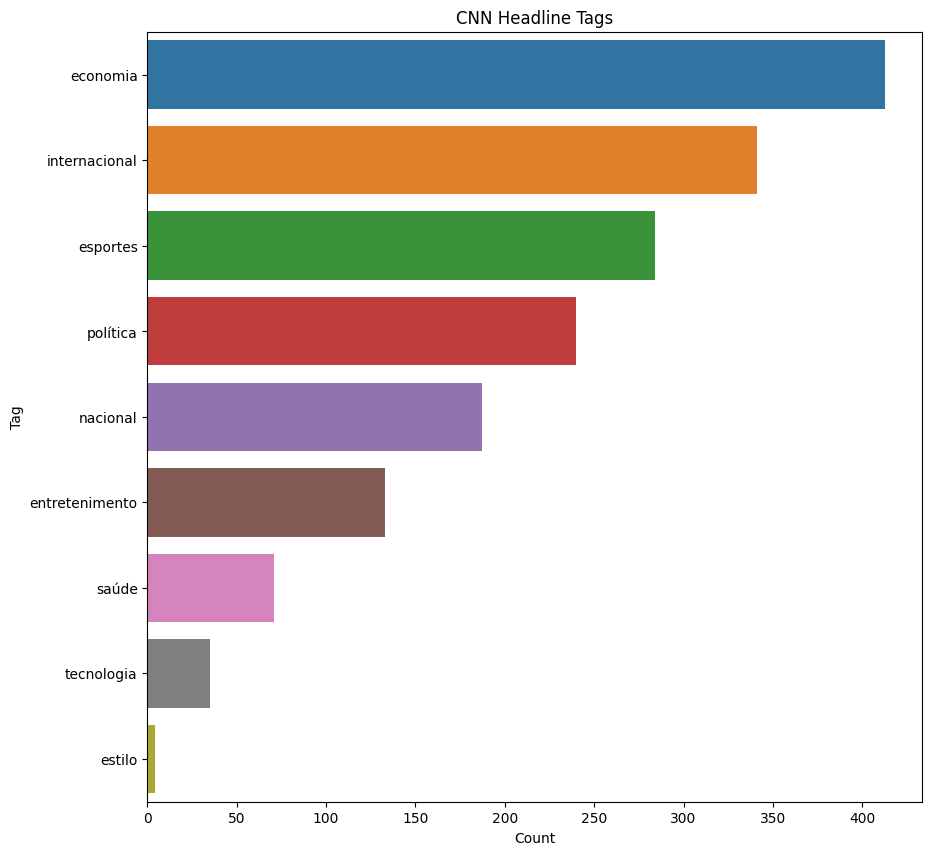

In [44]:
# Data visualization
figure = plt.figure(figsize=(10, 10))
sns.countplot(y="tag", data=df_news, order=df_news["tag"].value_counts().index)
plt.title("CNN Headline Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()

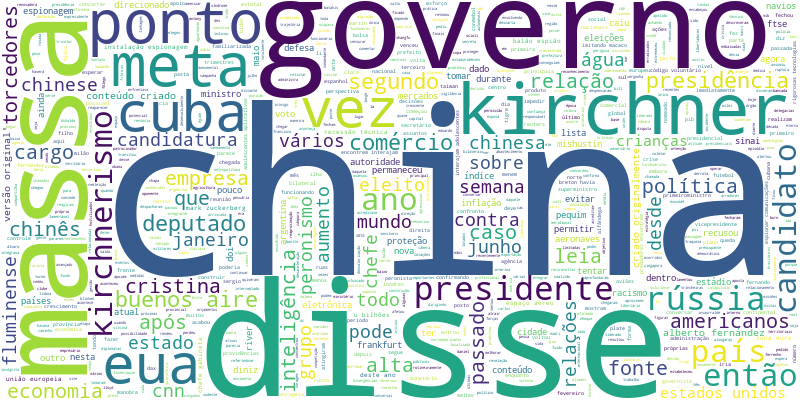

In [45]:
from wordcloud import WordCloud

wordcloud_config = { 
    "background_color": "white",
    "max_words": 5000,
    "contour_width": 3,
    "contour_color": 'steelblue',
    "width": 800,
    "height": 400,
}

text = df_news["text"].values
wordcloud = WordCloud(**wordcloud_config)
wordcloud.generate(str(text))
wordcloud.to_image()

In [46]:
import gensim

id2word = gensim.corpora.Dictionary(df_news["tokenized_text"])
corpus = [id2word.doc2bow(text) for text in df_news["tokenized_text"]]
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 5), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 2), (21, 3), (22, 1), (23, 4), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1)]


In [47]:
lda_model_config = {
    "corpus": corpus,
    "id2word": id2word,
    "num_topics": 10,
}

lda_model = gensim.models.LdaMulticore(**lda_model_config)

print(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0, '0.015*"”" + 0.011*"“" + 0.005*"disse" + 0.005*"ano" + 0.004*"leia" + 0.004*"após" + 0.004*"sobre" + 0.003*"presidente" + 0.003*"dia" + 0.003*"ainda"'), (1, '0.021*"“" + 0.018*"”" + 0.006*"disse" + 0.006*"ano" + 0.004*"sobre" + 0.004*"leia" + 0.004*"brasil" + 0.003*"dia" + 0.003*"pessoas" + 0.003*"presidente"'), (2, '0.018*"“" + 0.015*"”" + 0.006*"disse" + 0.005*"ano" + 0.004*"dia" + 0.004*"leia" + 0.003*"segundo" + 0.003*"pessoas" + 0.003*"sobre" + 0.003*"ainda"'), (3, '0.011*"“" + 0.010*"”" + 0.005*"disse" + 0.005*"ano" + 0.004*"cnn" + 0.004*"após" + 0.003*"sobre" + 0.003*"leia" + 0.003*"brasil" + 0.002*"ainda"'), (4, '0.016*"“" + 0.014*"”" + 0.006*"ano" + 0.005*"disse" + 0.004*"sobre" + 0.003*"ainda" + 0.003*"segundo" + 0.003*"pode" + 0.003*"pessoas" + 0.003*"dia"'), (5, '0.023*"”" + 0.014*"“" + 0.005*"disse" + 0.005*"ano" + 0.004*"sobre" + 0.003*"ainda" + 0.003*"pode" + 0.003*"segundo" + 0.003*"leia" + 0.003*"após"'), (6, '0.014*"”" + 0.012*"“" + 0.005*"disse" + 0.005*"ano" + 

In [51]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
import os
import pathlib

pyLDAvis.enable_notebook()
result_path = pathlib.Path("../../data/results/").resolve()

if not result_path.exists():
    result_path.mkdir(parents=True, exist_ok=True)

result_path_output = result_path.joinpath("lda_model.pkl")

if not result_path_output.is_file():
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, lda_model_config["corpus"], lda_model_config["id2word"])
    with open(result_path_output, "wb") as f:
        pickle.dump(LDAvis_prepared, f)

In [52]:
if result_path.is_file(): 
    with open(result_path, "rb") as f:
        LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, f"../../data/results/ldavis_prepared_{lda_model_config['num_topics']}.html")
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.012961 -0.008161       1        1  22.438756
0     -0.007197 -0.002163       2        1  10.957401
2      0.003707  0.002033       3        1   9.869868
7     -0.006591 -0.013180       4        1   9.833670
4      0.007072  0.005147       5        1   9.695092
5      0.016761  0.003122       6        1   8.566703
8     -0.004710  0.016832       7        1   8.348613
3     -0.012461  0.007356       8        1   8.205175
6      0.002627 -0.003761       9        1   6.747128
9     -0.012168 -0.007224      10        1   5.337595, topic_info=        Term         Freq        Total Category  logprob  loglift
237        ”  6731.000000  6731.000000  Default  30.0000  30.0000
236        “  6999.000000  6999.000000  Default  29.0000  29.0000
83     disse  2358.000000  2358.000000  Default  28.0000  28.0000
263      ano  2400.000000  2400.000000  Default  27.0000  27.0000
113  governo   987.000000   987.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
32      caso    36.895345   648.944883  Topic10  -6.4859   0.0631
805   acordo    39.522647   955.075934  Topic10  -6.4172  -0.2545
45       cnn    37.616604   996.404578  Topic10  -6.4666  -0.3463
534      ter    35.665771   729.155971  Topic10  -6.5198  -0.0873
754  pessoas    36.470511  1072.070918  Topic10  -6.4975  -0.4504

[854 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
0          1  0.290442     a
0          2  0.114826     a
0          3  0.096814     a
0          4  0.076550     a
0          5  0.072048     a
...      ...       ...   ...
237        7  0.065508     ”
237        8  0.054368     ”
237        9  0.065360     ”
237       10  0.042335     ”
11136      9  0.612800  ☺️☺️

[2837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 8, 5, 6, 9, 4, 7, 10])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tf_idf(text):
    try: 
        vectorizer = TfidfVectorizer()
        tf_idf_matrix = vectorizer.fit_transform([text])
        return tf_idf_matrix.toarray()[0]
    except Exception: 
        return {}
    
df_news["tf_idf"] = df_news["text"].progress_apply(compute_tf_idf)

  0%|          | 0/1708 [00:00<?, ?it/s]

In [ ]:
df_news.head()

,topics,tag,text,creation_day,creation_month,creation_year,update_day,update_month,update_year,tf_idf
0,"[china, cuba, espionagem, estados unidos, joe ...",internacional,cuba concede permissão china construir instala...,8,6,2023,8.0,6.0,2023.0,"[0.035158127696731496, 0.035158127696731496, 0..."
1,"[argentina, eleições]",internacional,sergio massa reviravoltas kirchnerismo possíve...,8,6,2023,8.0,6.0,2023.0,"[0.028205406366325913, 0.056410812732651826, 0..."
2,"[cnn esportes, copa libertadores da américa, f...",esportes,fernando diniz critica caso racismo contra tor...,8,6,2023,8.0,6.0,2023.0,"[0.06482037235521644, 0.06482037235521644, 0.0..."
3,"[câmara dos deputados, deltan dallagnol, dias ...",política,stf começa julgar nesta sexta decisão sobre su...,8,6,2023,8.0,6.0,2023.0,"[0.04303314829119352, 0.04303314829119352, 0.0..."
4,"[cnn esportes, leila pereira, palmeiras]",esportes,avião leila pereira utilizado palmeiras chega ...,8,6,2023,NaN,NaN,NaN,"[0.06917144638660747, 0.27668578554642986, 0.1..."


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def search(query, corpus, top_n = 100):
    query = pre_processing(query)

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus["text"])
    query_vector = vectorizer.transform([query])

    similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

    df_similarity = pd.DataFrame(similarity_scores.T, index=range(len(corpus)), columns=["similarity"])
    return df_similarity.sort_values(by="similarity", ascending=False).head(top_n)

In [ ]:
def calculate_precision_k(query_results: pd.DataFrame, target: str, k: int) -> float:
    """Calculates the precision at k.

    Args:
        query_results (pd.DataFrame): The dataframe containing the results of the query.
        target (str): The target subreddit.
        k (int): The number of results to consider.

    Returns:
        float: The precision at k.
    """
    return query_results.head(k).apply(lambda x: x == target).sum() / k

def calculate_mean_average_precision(df_results: pd.DataFrame, target: str) -> float:
    """Calculates the mean average precision.

    Args:
        df_results (pd.DataFrame): The dataframe containing the results of the query.
        target (str): The target subreddit.
    
    Returns:
        float: The mean average precision.
    """
    return df_results.apply(lambda x: x == target).cumsum().div(df_results.index + 1).sum() / df_results.shape[0]   

def compute_metrics(df_results: pd.DataFrame, target: str):
    """Computes the following metrics: p10, p20, p50, p100, map.

    Args:
        df_results (pd.DataFrame): The dataframe containing the results of the query.
        target (str): The target subreddit.

    Returns:
        Dict[str, float]: A dictionary containing the metrics.
    """    
    metrics = {"p10": calculate_precision_k(df_results, target, 10)}
    metrics["p20"] = calculate_precision_k(df_results, target, 20)
    metrics["p50"] = calculate_precision_k(df_results, target, 50)
    metrics["p100"] = calculate_precision_k(df_results, target, 100)
    metrics["map"] = calculate_mean_average_precision(df_results, target)

    return metrics